## Tarefas de regressão linear na base de dados do ENEM.

##### Alunos:
- Gabriel Fonseca (2111066)
- Yasmim Santos (2116925)
- Alejandro Elias (2111189)
- Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859

### Importando as dependências:

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Lendo e visualizando os dados:

In [59]:
# Anos de 2015 a 2022
anos = [
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
]

dtype = {
    "id_inscricao": "Int64",
    "ensino": "Int32",
    "nota_ciencias_natureza": float,
    "nota_ciencias_humanas": float,
    "nota_linguagens_codigos": float,
    "nota_matematica": float,
    "nota_redacao": float,
    "q_formacao_pai": str,
    "q_formacao_mae": str,
    "q_renda_familia": str,
}

dfs_por_ano = []

for ano in anos:
    df = pd.read_csv(f"../../data/enem-microdados-qsce/{ano}.csv", dtype=dtype)
    df["ano"] = int(ano)
    dfs_por_ano.append(df)


df_enem = pd.concat(dfs_por_ano, ignore_index=True).reset_index(drop=True)

colunas = ["q_formacao_pai", "q_formacao_mae", "q_renda_familia"]
df_enem[colunas] = df_enem[colunas].replace("*", np.nan).replace(".", np.nan)
df_enem = df_enem.dropna().reset_index(drop=True)

df_enem

,id_inscricao,ensino,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao,q_formacao_pai,q_formacao_mae,q_renda_familia,ano
0,150001892848,3,366.8,436.9,374.2,331.4,380.0,B,A,C,2015
1,150002421428,1,512.0,636.9,552.0,549.2,760.0,A,A,C,2015
2,150004396764,1,470.8,519.3,465.2,350.8,580.0,B,A,B,2015
3,150001657786,1,492.6,641.2,553.2,649.5,840.0,A,A,A,2015
4,150005415838,1,473.3,533.4,443.3,447.4,400.0,A,A,A,2015
...,...,...,...,...,...,...,...,...,...,...,...
357268,210054596750,1,450.6,403.1,443.3,479.8,0.0,E,E,B,2022
357269,210056286560,1,416.5,427.3,484.6,376.2,0.0,D,D,A,2022
357270,210057495281,1,462.1,421.7,432.1,530.9,0.0,C,D,B,2022
357271,210056812211,1,519.1,570.4,537.3,388.7,0.0,D,H,B,2022


In [60]:
df_enem.describe()

,id_inscricao,ensino,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao,ano
count,357273.0,357273.0,357273.000000,357273.000000,357273.000000,357273.000000,357273.000000,357273.000000
mean,188253176809.990814,1.135602,460.400028,483.735685,467.353657,480.318531,240.837483,2018.974473
std,18571876723.88229,0.495421,81.503688,98.631326,86.237517,110.557558,318.649495,2.056472
min,150000002282.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,180007908536.0,1.0,403.700000,415.200000,406.800000,404.800000,0.000000,2018.000000
50%,190002760563.0,1.0,440.300000,468.000000,457.400000,449.200000,0.000000,2019.000000
75%,210052018732.0,1.0,494.500000,539.500000,515.700000,519.400000,380.000000,2021.000000
max,210058030240.0,3.0,871.300000,862.600000,803.800000,993.000000,1000.000000,2022.000000


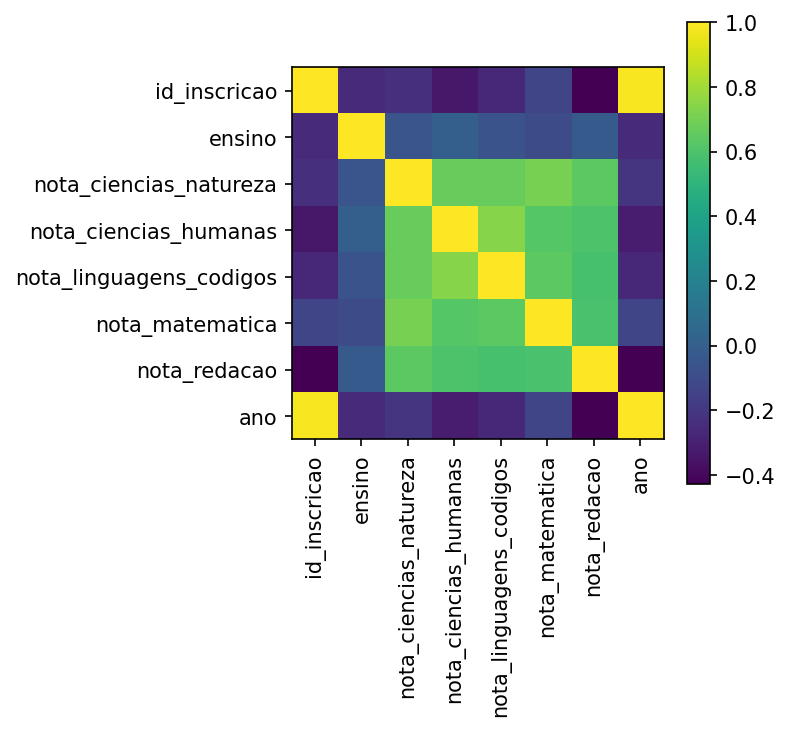

In [61]:
correlation = df_enem.select_dtypes(include="number").corr()

columns = correlation.columns
num_labels = len(columns)
itv_num_labels = range(num_labels)

plt.figure(figsize=(4, 4), dpi=150)
plt.xticks(itv_num_labels, labels=columns, rotation=90)
plt.yticks(itv_num_labels, labels=columns)
plt.imshow(correlation)
plt.colorbar()
plt.show()

### Preparando os dados para utilização no modelo:

Para a realização da regressão, é necessário que os valores que estamos utilizar como base para a relação sejam numéricos.
Os valores em momento se tratam das respostas nas questões:
  - `Até quando seu pai estudou?`
  - `Até quando sua mãe estudou?`
  - `Somando a sua renda com a renda das pessoas que moram com você, quanto é, aproximadamente, a renda familiar? (Considere a renda de todos que moram na sua casa.)`

Que se tratam de perguntas referentes ao nível de renda do estudante que fez ENEM.

As questões estão organizadas em ordem crescente, onde o quão "maior" a letra do alfabeto (entre A e I), maior a renda da família do estudante.

Essas questões e suas alternativas foram retiradas do [Manual do Inscrito e Questionário Socioeconômico de 2009](https://download.uol.com.br/educacao/enem2009/quest_socioec_enem2009.pdf).

Claramente o questionário socioeconômico não permaneceu o mesmo durante os anos, e as perguntas escolhidas foram escolhidas especificamente por serem constantes presentes nos questionários de 2015 a 2022.

O mapeamento das respostas para a pontuação foi realizado com as informações presentes na [tabela de dicionário](https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859?table=4ae54d49-bdde-482c-a766-f491af59065f) disponibilizada pelo site BancoDosDados onde conseguimos nosso Dataset, que contem metadados sobre a tabela e o que os dados lá presentes significam.

In [62]:
# Item 'H' será removido do Dataset pois corresponde a resposta 'Não sei'
possiveis_opcoes_q_formacao = ["A", "B", "C", "D", "E", "F", "G"]
passada_scores_q_formacao = np.linspace(0, 1, len(possiveis_opcoes_q_formacao) + 1)
dict_respostas_para_pontos_q_formacao = dict(zip(possiveis_opcoes_q_formacao, passada_scores_q_formacao[1:]))

possiveis_opcoes_q_renda_familia = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q"]
passada_scores_q_renda_familia = np.linspace(0, 1, len(possiveis_opcoes_q_renda_familia) + 1)
dict_respostas_para_pontos_q_renda_familia = dict(zip(possiveis_opcoes_q_renda_familia, passada_scores_q_renda_familia[1:]))

df_enem = df_enem.loc[~df_enem["q_formacao_pai"].str.contains("H")]
df_enem = df_enem.loc[~df_enem["q_formacao_mae"].str.contains("H")]

df_enem["q_formacao_pai_score"] = df_enem["q_formacao_pai"].map(
    dict_respostas_para_pontos_q_formacao
)
df_enem["q_formacao_mae_score"] = df_enem["q_formacao_mae"].map(
    dict_respostas_para_pontos_q_formacao
)

df_enem["q_renda_familia_score"] = df_enem["q_renda_familia"].map(
    dict_respostas_para_pontos_q_renda_familia
)

df_enem = df_enem.dropna(axis=0, how="any")
df_enem.reset_index(drop=True)

df_enem

,id_inscricao,ensino,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao,q_formacao_pai,q_formacao_mae,q_renda_familia,ano,q_formacao_pai_score,q_formacao_mae_score,q_renda_familia_score
0,150001892848,3,366.8,436.9,374.2,331.4,380.0,B,A,C,2015,0.285714,0.142857,0.176471
1,150002421428,1,512.0,636.9,552.0,549.2,760.0,A,A,C,2015,0.142857,0.142857,0.176471
2,150004396764,1,470.8,519.3,465.2,350.8,580.0,B,A,B,2015,0.285714,0.142857,0.117647
3,150001657786,1,492.6,641.2,553.2,649.5,840.0,A,A,A,2015,0.142857,0.142857,0.058824
4,150005415838,1,473.3,533.4,443.3,447.4,400.0,A,A,A,2015,0.142857,0.142857,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357267,210057185566,1,433.4,388.8,383.0,376.1,0.0,E,E,B,2022,0.714286,0.714286,0.117647
357268,210054596750,1,450.6,403.1,443.3,479.8,0.0,E,E,B,2022,0.714286,0.714286,0.117647
357269,210056286560,1,416.5,427.3,484.6,376.2,0.0,D,D,A,2022,0.571429,0.571429,0.058824
357270,210057495281,1,462.1,421.7,432.1,530.9,0.0,C,D,B,2022,0.428571,0.571429,0.117647


In [63]:
features = [
    "q_formacao_pai_score",
    "q_formacao_mae_score",
    "q_renda_familia_score",
]

X = np.array(df_enem[features])
Y = np.array(df_enem["nota_redacao"])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=0.8, random_state=5487
)

X_train: np.ndarray = X_train
Y_train: np.ndarray = Y_train
X_test: np.ndarray = X_test
Y_test: np.ndarray = Y_test

pd.DataFrame(X_train).head()

,0,1,2
0,0.571429,0.714286,0.470588
1,0.714286,0.714286,0.117647
2,0.571429,0.714286,0.176471
3,0.428571,0.285714,0.117647
4,0.142857,0.142857,0.117647


### Realizando a regressão:

In [64]:
model = LinearRegression()
model.fit(X_train, Y_train)

print(f"""
Intercept: {model.intercept_}
Coeficiente(s): {model.coef_}
""".strip())

Intercept: 97.08969132605398
Coeficiente(s): [-66.35561547 -21.87808612 880.57860212]


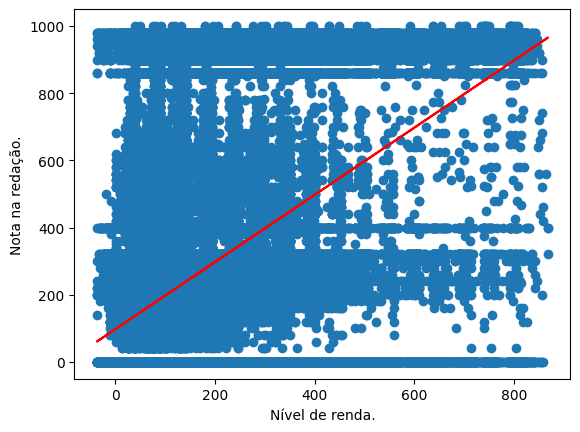

In [65]:
plt.ylabel('Nota na redação.')
plt.xlabel('Nível de renda.')

X_plt = X_train @ model.coef_.T
Y_plt = Y_train

model_x = X_plt
model_y = model.intercept_ + X_plt

plt.scatter(X_plt, Y_plt)
plt.plot(model_x, model_y, 'r-')
plt.show()